Simulating subject 2 with RL model...
  True probs: [0.33333333 0.15384615 0.02564103 0.48717949]
  Sim probs:  [0.25984211 0.07305263 0.08505263 0.58205263]
Simulating subject 10 with PT model...
  True probs: [0.375 0.025 0.125 0.475]
  Sim probs:  [0.3372  0.14955 0.12105 0.3922 ]
Simulating subject 1 with Hybrid model...
  True probs: [0.4   0.125 0.    0.475]
  Sim probs:  [0.4581  0.0614  0.00415 0.47635]


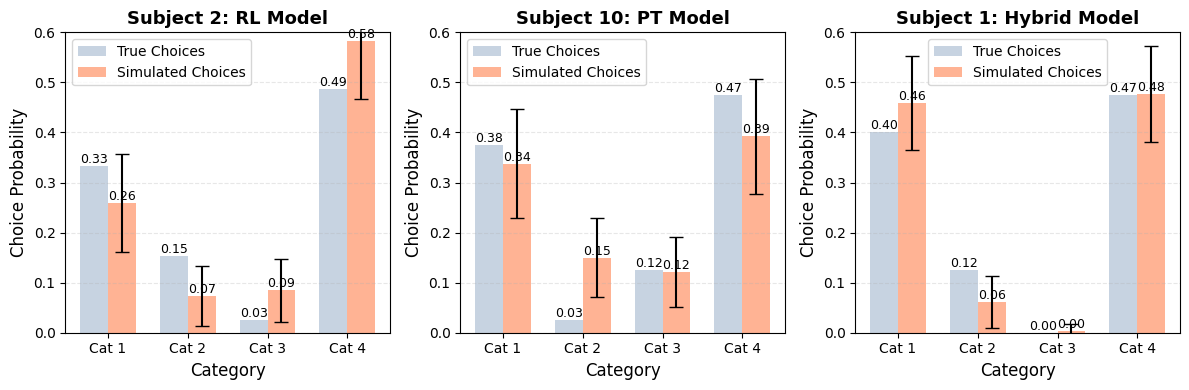


Posterior Predictive Check Complete!
Plot saved as 'posterior_predictive_check.png'

Simulations run: 1000 per subject

Error bars represent standard deviation across simulation runs


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# Utility Functions
# ==========================================

def softmax(x, beta=1.0):
    """Softmax function with stability adjustment."""
    ex = np.exp(beta * (x - np.max(x)))
    return ex / ex.sum()

def compute_empirical_category_distributions(df):
    """Compute global empirical distributions for PT model."""
    dists = {}
    cat_col = 'category_idx' if 'category_idx' in df.columns else 'cat'
    
    if df[cat_col].min() == 0:
        df = df.copy()
        df[cat_col] = df[cat_col] + 1
    
    for cat in [1, 2, 3, 4]:
        vals = df[df[cat_col] == cat]['reward'].dropna().values
        if len(vals) == 0:
            dists[cat] = (np.array([0.0, 1.0]), np.array([0.0, 0.0]))
        else:
            unique, counts = np.unique(vals, return_counts=True)
            probs = counts / counts.sum()
            dists[cat] = (unique, probs)
    return dists

def prelec_weight(p, gamma):
    """Prelec (1998) probability weighting function."""
    p = np.clip(p, 1e-12, 1.0)
    return np.exp(-(-np.log(p)) ** gamma)

def subjective_EV_for_category(cat, alpha_val, gamma_val, category_dists):
    """Calculate PT-adjusted subjective expected value for a category."""
    outcomes, probs = category_dists[cat]
    u = outcomes ** alpha_val
    w = prelec_weight(probs, gamma_val)
    if w.sum() == 0:
        w = probs
    else:
        w = w / w.sum()
    return np.sum(w * u)

# ==========================================
# Simulation Functions
# ==========================================

def simulate_rl_model(sub_df, alpha, beta, q0=2.5):
    """Simulate choices using standard RL model."""
    choices = sub_df['category_idx'].astype(int).values
    rewards = sub_df['reward'].astype(float).values
    
    Q = np.ones(4) * q0
    simulated_choices = []
    
    for i, (c, r) in enumerate(zip(choices, rewards)):
        # Calculate choice probabilities
        probs = softmax(Q, beta=beta)
        
        # Simulate choice
        sim_choice = np.random.choice([1, 2, 3, 4], p=probs)
        simulated_choices.append(sim_choice)
        
        # Update Q-values based on ACTUAL choice (to match the true trajectory)
        c_idx = c - 1
        Q[c_idx] = Q[c_idx] + alpha * (r - Q[c_idx])
    
    return np.array(simulated_choices)

def simulate_pt_model(sub_df, alpha, gamma, beta, category_dists):
    """Simulate choices using Static PT model."""
    # Calculate static subjective EVs
    sEV = np.array([subjective_EV_for_category(cat, alpha, gamma, category_dists) 
                    for cat in [1, 2, 3, 4]])
    
    # Calculate choice probabilities (constant throughout)
    probs = softmax(sEV, beta=beta)
    
    # Simulate choices
    n_trials = len(sub_df)
    simulated_choices = np.random.choice([1, 2, 3, 4], size=n_trials, p=probs)
    
    return simulated_choices

def simulate_hybrid_likeability(sub_df, alpha, beta, omega, q0=2.5):
    """Simulate choices using Hybrid RL + Likeability model."""
    # Standardize likeability ratings
    like_cols = ['like_cat1', 'like_cat2', 'like_cat3', 'like_cat4']
    like_matrix = sub_df[like_cols].values
    
    # Standardize within subject (assuming already done in data)
    
    choices = sub_df['category_idx'].astype(int).values
    rewards = sub_df['reward'].astype(float).values
    
    Q = np.ones(4) * q0
    simulated_choices = []
    
    for i, (c, r) in enumerate(zip(choices, rewards)):
        likes = like_matrix[i]
        
        # Combined value: V = beta*Q + omega*L
        v_values = (beta * Q) + (omega * likes)
        
        # Calculate choice probabilities
        probs = softmax(v_values, beta=1.0)
        
        # Simulate choice
        sim_choice = np.random.choice([1, 2, 3, 4], p=probs)
        simulated_choices.append(sim_choice)
        
        # Update Q-values based on ACTUAL choice
        c_idx = c - 1
        Q[c_idx] = Q[c_idx] + alpha * (r - Q[c_idx])
    
    return np.array(simulated_choices)

# ==========================================
# Main Analysis
# ==========================================

# Load data
df_master = pd.read_csv('02_Master_df.txt')

# Filter for trials 20-40 (questions 40-60)
df_test = df_master[df_master['trial'].between(20, 40)].copy()

# Compute global empirical distributions (for PT model)
category_dists = compute_empirical_category_distributions(df_master)

# Define subjects and their fitted parameters
subjects_info = {
    2: {'model': 'RL', 'params': {'alpha': 0.097, 'beta': 3.030}},
    10: {'model': 'PT', 'params': {'alpha': 4.793, 'gamma': 3.491, 'beta': 0.002}},
    1: {'model': 'Hybrid', 'params': {'alpha': 0.076, 'beta': 11.577, 'omega': 1.328}}
}

# Run simulations (multiple runs for stability)
n_simulations = 1000
results = {}

for sub_id, info in subjects_info.items():
    print(f"Simulating subject {sub_id} with {info['model']} model...")
    
    # Get subject data for trials 20-40
    sub_test = df_test[df_test['subject_id'] == sub_id].copy()
    
    # Get full subject data (for model initialization)
    sub_full = df_master[df_master['subject_id'] == sub_id].copy()
    
    if len(sub_test) == 0:
        print(f"  Warning: No test data for subject {sub_id}")
        continue
    
    # Get true choices
    true_choices = sub_full['category_idx'].values
    
    # Run multiple simulations
    all_sim_choices = []
    
    for sim in range(n_simulations):
        if info['model'] == 'RL':
            sim_choices = simulate_rl_model(
                sub_full, 
                info['params']['alpha'], 
                info['params']['beta']
            )
        elif info['model'] == 'PT':
            sim_choices = simulate_pt_model(
                sub_full,
                info['params']['alpha'],
                info['params']['gamma'],
                info['params']['beta'],
                category_dists
            )
        elif info['model'] == 'Hybrid':
            sim_choices = simulate_hybrid_likeability(
                sub_full,
                info['params']['alpha'],
                info['params']['beta'],
                info['params']['omega']
            )
        
        # Extract only test trials (20-40)
        sim_choices_test = sim_choices[20:41]
        all_sim_choices.append(sim_choices_test)
    
    # Convert to array
    all_sim_choices = np.array(all_sim_choices)
    
    # Calculate choice probabilities
    true_probs = np.array([np.mean(true_choices == cat) for cat in [1, 2, 3, 4]])
    sim_probs = np.array([np.mean(all_sim_choices == cat) for cat in [1, 2, 3, 4]])
    sim_probs_std = np.array([np.std(np.mean(all_sim_choices == cat, axis=1)) for cat in [1, 2, 3, 4]])
    
    results[sub_id] = {
        'true_probs': true_probs,
        'sim_probs': sim_probs,
        'sim_probs_std': sim_probs_std,
        'model': info['model']
    }
    
    print(f"  True probs: {true_probs}")
    print(f"  Sim probs:  {sim_probs}")

# ==========================================
# Plotting
# ==========================================

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, (sub_id, data) in enumerate(results.items()):
    ax = axes[idx]
    
    categories = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4']
    x = np.arange(len(categories))
    width = 0.35
    
    # Plot bars
    bars1 = ax.bar(x - width/2, data['true_probs'], width, 
                   label='True Choices', color='#b9c8da', alpha=0.8)
    bars2 = ax.bar(x + width/2, data['sim_probs'], width,
                   label='Simulated Choices', color='lightsalmon', alpha=0.8,
                   yerr=data['sim_probs_std'], capsize=5)
    
    # Formatting
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel('Choice Probability', fontsize=12)
    ax.set_title(f'Subject {sub_id}: {data["model"]} Model', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend(fontsize=10)
    ax.set_ylim([0, max(0.6, data['true_probs'].max() * 1.2)])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('posterior_predictive_check.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Posterior Predictive Check Complete!")
print("="*60)
print(f"Plot saved as 'posterior_predictive_check.png'")
print(f"\nSimulations run: {n_simulations} per subject")
print("\nError bars represent standard deviation across simulation runs")